In [1]:
import torch
from torch import nn
import copy
from collections import deque
import random
from tqdm import tqdm
import gym
import matplotlib.pyplot as plt
from datetime import datetime
from collections import namedtuple
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from machine import Machine
from GymMachEnv import MachineEnv

In [3]:
Transition = namedtuple('Transition', ('state', 'next_state', 'action', 'reward', 'mask'))

def tensorboard_func(array,name):
    writer = SummaryWriter(name)
    
    for x in array:
        writer.add_scalar('log/Average_score', x[0], x[1])

class Memory(object):
    def __init__(self, capacity):
        self.memory = []
        self.capacity = capacity
        self.position = 0

    def push(self, state, next_state, action, reward, mask):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(Transition(state, next_state, action, reward, mask))
        self.memory[self.position] = Transition(state, next_state, action, reward, mask)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        transitions = random.sample(self.memory, batch_size)
        batch = Transition(*zip(*transitions))
        return batch

    def __len__(self):
        return len(self.memory)

class DoubleDQNet(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(DoubleDQNet, self).__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs

        self.fc1 = nn.Linear(num_inputs, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_outputs)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        qvalue = self.fc3(x)
        return qvalue

    @classmethod
    def train_model(cls, online_net, target_net, optimizer, batch, gamma):
        states = torch.stack(batch.state)
        next_states = torch.stack(batch.next_state)
        actions = torch.Tensor(batch.action).float()
        rewards = torch.Tensor(batch.reward)
        masks = torch.Tensor(batch.mask)

        pred = online_net(states).squeeze(1)
        _, action_from_online_net = online_net(next_states).squeeze(1).max(1)
        next_pred = target_net(next_states).squeeze(1)

        pred = torch.sum(pred.mul(actions), dim=1)

        target = rewards + masks * gamma * next_pred.gather(1, action_from_online_net.unsqueeze(1)).squeeze(1)


        loss = F.mse_loss(pred, target.detach())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss

    def get_action(self, input):
        qvalue = self.forward(input)
        _, action = torch.max(qvalue, 1)
        return action.numpy()[0]

def get_action(state, target_net, epsilon, env):
    if np.random.rand() <= epsilon:
        return env.action_space.sample()
    else:
        return target_net.get_action(state)


def update_target_model(online_net, target_net):
    # Target -> Net
    target_net.load_state_dict(online_net.state_dict())
    
def compute_avg_return(environment, policy, num_episodes):
    total_return = 0.0
    for _ in range(num_episodes):
        state = torch.Tensor(environment.reset())
        state = state.unsqueeze(0)
        episode_return = 0.0 
        while not environment.done:
            action = get_action(state, policy, 0.1, environment)
            next_state, reward, done, _ = environment.step(action)
            next_state = torch.Tensor(next_state)
            next_state = next_state.unsqueeze(0)
            state = next_state
            episode_return += reward
        total_return += episode_return   
    avg_return = total_return / num_episodes
    return avg_return# Evaluate the agent's policy once before training.

In [10]:
def evaluate_and_test(params,trial_number,folder): #trial function that trains and stores results into array
    
    max_episodes = 50000
    
    #Train Env
    machine = Machine()
    machine.curr_state = 0
    env = MachineEnv(machine)

    #Eval Env
    machine2 = Machine()
    machine2.curr_state = 0
    env2 = MachineEnv(machine2)

    online_net = DoubleDQNet(4, 2)
    target_net = DoubleDQNet(4, 2)
    update_target_model(online_net, target_net)
    
    optimizer = optim.Adam(online_net.parameters(), lr=params[0])
    online_net.train()
    target_net.train()
    memory = Memory(10000)
    
    #start_time = datetime.now().replace(microsecond=0)

    running_score = 0
    epsilon = 1.0
    steps = 0
    loss = 0
    initial_exploration = 1000
    log_interval = 10
    
    tracker = [[0,0]]
    max_average = 0
    
    for e in range(max_episodes):
        done = False

        score = 0
        state = env.reset()
        state = torch.Tensor(state)
        state = state.unsqueeze(0)
        while not done:
            steps += 1
            action = get_action(state, target_net, epsilon, env)
            next_state, reward, done, _ = env.step(action)

            next_state = torch.Tensor(next_state)
            next_state = next_state.unsqueeze(0)

            mask = 0 if done else 1
            action_one_hot = np.zeros(2)
            action_one_hot[action] = 1
            memory.push(state, next_state, action_one_hot, reward, mask)

            score += reward
            state = next_state

            if steps > initial_exploration:
                epsilon -= params[2]
                epsilon = max(epsilon, 0.1)

                batch = memory.sample(64)
                loss = DoubleDQNet.train_model(online_net, target_net, optimizer, batch,params[1])

                if steps % params[3] == 0:
                    update_target_model(online_net, target_net)

        if e % log_interval == 0:
            if e == 0: continue
            eval_score = compute_avg_return(env2,online_net,20) #take average of 20 episodic scores in an evaluation env
            print('{} episode | Ave val score over 20 ep: {:.2f} | epsilon: {:.2f}'.format(
                e, eval_score, epsilon))
            tracker.append([eval_score,e])
            
            move_ave_score = np.mean(np.array(tracker)[-50:,0])
            if max_average < move_ave_score:
                torch.save(online_net,f'{folder}/trial_{trial_number}_dqn_agent_.pt')
                max_average = move_ave_score

    np.savetxt(f'{folder}/trial_{trial_number}.txt', tracker, delimiter=',',fmt='%s')
    torch.save(online_net,f'{folder}/final_trial_{trial_number}_dqn_agent.pt')
    
    return np.array(tracker)

In [17]:
params = {
 'lr' : [1e-04,1e-03,1e-02,1e-01],
 'gamma' : [0.80,0.90,0.95,0.99],
 'epsilon_decay': [1e-05,1e-04,1e-03,1e-02],
 'update_freq' : [50,100,150,200]
}

In [18]:
def gen_param_array(l16_array):
    full = []
    for row in range(len(l16_array)):
        x = l16_array[row]
        arr_params = []
        
        for col in range(len(x)):
            list_params = list(params.values())[col]
            value = list_params[x[col]]
            arr_params.append(value)
        print(arr_params)
        full.append(arr_params)
    return full

In [19]:
l16_array = np.array(pd.read_csv('L16.txt',header=None, sep='\t'))

In [20]:
params_array = gen_param_array(l16_array)

[0.0001, 0.8, 1e-05, 50]
[0.0001, 0.9, 0.0001, 100]
[0.0001, 0.95, 0.001, 150]
[0.0001, 0.99, 0.01, 200]
[0.001, 0.8, 0.0001, 150]
[0.001, 0.9, 1e-05, 200]
[0.001, 0.95, 0.01, 50]
[0.001, 0.99, 0.001, 100]
[0.01, 0.8, 0.001, 200]
[0.01, 0.9, 0.01, 150]
[0.01, 0.95, 1e-05, 100]
[0.01, 0.99, 0.0001, 50]
[0.1, 0.8, 0.01, 100]
[0.1, 0.9, 0.001, 50]
[0.1, 0.95, 0.0001, 200]
[0.1, 0.99, 1e-05, 150]


In [5]:
def train(params_array,folder_name):
    trial = 0
    for sets in params_array:
        print("trial ",trial)
#         if trial in [0,1,2]: 
#             trial+=1
#             continue
        evaluate_and_test(sets,trial,folder_name)
        trial+=1

In [ ]:
# folder_name = 'run_1'
# train(params_array,folder_name)

In [ ]:
best_params = [1e-01,0.99,1e-03,150]
default_params = [0.001,0.99,0.001,100]

In [11]:
evaluate_and_test([1e-01,0.99,1e-03,150],0,'best')

10 episode | Ave val score over 20 ep: 2040.00 | epsilon: 1.00
20 episode | Ave val score over 20 ep: 6580.00 | epsilon: 0.86
30 episode | Ave val score over 20 ep: 4400.00 | epsilon: 0.53
40 episode | Ave val score over 20 ep: 7705.00 | epsilon: 0.27
50 episode | Ave val score over 20 ep: 5895.00 | epsilon: 0.10
60 episode | Ave val score over 20 ep: 4985.00 | epsilon: 0.10
70 episode | Ave val score over 20 ep: 7425.00 | epsilon: 0.10
80 episode | Ave val score over 20 ep: 5425.00 | epsilon: 0.10
90 episode | Ave val score over 20 ep: 5950.00 | epsilon: 0.10
100 episode | Ave val score over 20 ep: 6640.00 | epsilon: 0.10
110 episode | Ave val score over 20 ep: 6385.00 | epsilon: 0.10
120 episode | Ave val score over 20 ep: 7950.00 | epsilon: 0.10
130 episode | Ave val score over 20 ep: 3960.00 | epsilon: 0.10
140 episode | Ave val score over 20 ep: 8555.00 | epsilon: 0.10
150 episode | Ave val score over 20 ep: 5780.00 | epsilon: 0.10
160 episode | Ave val score over 20 ep: 6645.00 |

1280 episode | Ave val score over 20 ep: 11255.00 | epsilon: 0.10
1290 episode | Ave val score over 20 ep: 11815.00 | epsilon: 0.10
1300 episode | Ave val score over 20 ep: 22350.00 | epsilon: 0.10
1310 episode | Ave val score over 20 ep: 9390.00 | epsilon: 0.10
1320 episode | Ave val score over 20 ep: 26305.00 | epsilon: 0.10
1330 episode | Ave val score over 20 ep: 30920.00 | epsilon: 0.10
1340 episode | Ave val score over 20 ep: 32770.00 | epsilon: 0.10
1350 episode | Ave val score over 20 ep: 23995.00 | epsilon: 0.10
1360 episode | Ave val score over 20 ep: 13240.00 | epsilon: 0.10
1370 episode | Ave val score over 20 ep: 14075.00 | epsilon: 0.10
1380 episode | Ave val score over 20 ep: 29720.00 | epsilon: 0.10
1390 episode | Ave val score over 20 ep: 20600.00 | epsilon: 0.10
1400 episode | Ave val score over 20 ep: 26760.00 | epsilon: 0.10
1410 episode | Ave val score over 20 ep: 11120.00 | epsilon: 0.10
1420 episode | Ave val score over 20 ep: 20780.00 | epsilon: 0.10
1430 episod

2530 episode | Ave val score over 20 ep: 30100.00 | epsilon: 0.10
2540 episode | Ave val score over 20 ep: 11915.00 | epsilon: 0.10
2550 episode | Ave val score over 20 ep: 17670.00 | epsilon: 0.10
2560 episode | Ave val score over 20 ep: 31765.00 | epsilon: 0.10
2570 episode | Ave val score over 20 ep: 25635.00 | epsilon: 0.10
2580 episode | Ave val score over 20 ep: 27135.00 | epsilon: 0.10
2590 episode | Ave val score over 20 ep: 18015.00 | epsilon: 0.10
2600 episode | Ave val score over 20 ep: 21875.00 | epsilon: 0.10
2610 episode | Ave val score over 20 ep: 8970.00 | epsilon: 0.10
2620 episode | Ave val score over 20 ep: 21450.00 | epsilon: 0.10
2630 episode | Ave val score over 20 ep: 27020.00 | epsilon: 0.10
2640 episode | Ave val score over 20 ep: 14115.00 | epsilon: 0.10
2650 episode | Ave val score over 20 ep: 10495.00 | epsilon: 0.10
2660 episode | Ave val score over 20 ep: 22030.00 | epsilon: 0.10
2670 episode | Ave val score over 20 ep: 25565.00 | epsilon: 0.10
2680 episod

3780 episode | Ave val score over 20 ep: 9895.00 | epsilon: 0.10
3790 episode | Ave val score over 20 ep: 14105.00 | epsilon: 0.10
3800 episode | Ave val score over 20 ep: 8105.00 | epsilon: 0.10
3810 episode | Ave val score over 20 ep: 20130.00 | epsilon: 0.10
3820 episode | Ave val score over 20 ep: 1495.00 | epsilon: 0.10
3830 episode | Ave val score over 20 ep: 10190.00 | epsilon: 0.10
3840 episode | Ave val score over 20 ep: 11860.00 | epsilon: 0.10
3850 episode | Ave val score over 20 ep: 22965.00 | epsilon: 0.10
3860 episode | Ave val score over 20 ep: 7125.00 | epsilon: 0.10
3870 episode | Ave val score over 20 ep: 13430.00 | epsilon: 0.10
3880 episode | Ave val score over 20 ep: 22510.00 | epsilon: 0.10
3890 episode | Ave val score over 20 ep: 24055.00 | epsilon: 0.10
3900 episode | Ave val score over 20 ep: 21705.00 | epsilon: 0.10
3910 episode | Ave val score over 20 ep: 22965.00 | epsilon: 0.10
3920 episode | Ave val score over 20 ep: 16095.00 | epsilon: 0.10
3930 episode |

5030 episode | Ave val score over 20 ep: 11275.00 | epsilon: 0.10
5040 episode | Ave val score over 20 ep: 33230.00 | epsilon: 0.10
5050 episode | Ave val score over 20 ep: 24955.00 | epsilon: 0.10
5060 episode | Ave val score over 20 ep: 23325.00 | epsilon: 0.10
5070 episode | Ave val score over 20 ep: 29970.00 | epsilon: 0.10
5080 episode | Ave val score over 20 ep: 25490.00 | epsilon: 0.10
5090 episode | Ave val score over 20 ep: 31820.00 | epsilon: 0.10
5100 episode | Ave val score over 20 ep: 15970.00 | epsilon: 0.10
5110 episode | Ave val score over 20 ep: 27305.00 | epsilon: 0.10
5120 episode | Ave val score over 20 ep: 28235.00 | epsilon: 0.10
5130 episode | Ave val score over 20 ep: 34625.00 | epsilon: 0.10
5140 episode | Ave val score over 20 ep: 30060.00 | epsilon: 0.10
5150 episode | Ave val score over 20 ep: 25150.00 | epsilon: 0.10
5160 episode | Ave val score over 20 ep: 30785.00 | epsilon: 0.10
5170 episode | Ave val score over 20 ep: 21430.00 | epsilon: 0.10
5180 episo

6280 episode | Ave val score over 20 ep: 30290.00 | epsilon: 0.10
6290 episode | Ave val score over 20 ep: 21715.00 | epsilon: 0.10
6300 episode | Ave val score over 20 ep: 21025.00 | epsilon: 0.10
6310 episode | Ave val score over 20 ep: 13645.00 | epsilon: 0.10
6320 episode | Ave val score over 20 ep: 29655.00 | epsilon: 0.10
6330 episode | Ave val score over 20 ep: 31870.00 | epsilon: 0.10
6340 episode | Ave val score over 20 ep: 14880.00 | epsilon: 0.10
6350 episode | Ave val score over 20 ep: 12120.00 | epsilon: 0.10
6360 episode | Ave val score over 20 ep: 21365.00 | epsilon: 0.10
6370 episode | Ave val score over 20 ep: 17395.00 | epsilon: 0.10
6380 episode | Ave val score over 20 ep: 13965.00 | epsilon: 0.10
6390 episode | Ave val score over 20 ep: 20665.00 | epsilon: 0.10
6400 episode | Ave val score over 20 ep: 22645.00 | epsilon: 0.10
6410 episode | Ave val score over 20 ep: 7320.00 | epsilon: 0.10
6420 episode | Ave val score over 20 ep: 16350.00 | epsilon: 0.10
6430 episod

7530 episode | Ave val score over 20 ep: 13425.00 | epsilon: 0.10
7540 episode | Ave val score over 20 ep: 8355.00 | epsilon: 0.10
7550 episode | Ave val score over 20 ep: 9820.00 | epsilon: 0.10
7560 episode | Ave val score over 20 ep: 7815.00 | epsilon: 0.10
7570 episode | Ave val score over 20 ep: 9140.00 | epsilon: 0.10
7580 episode | Ave val score over 20 ep: 9115.00 | epsilon: 0.10
7590 episode | Ave val score over 20 ep: 8905.00 | epsilon: 0.10
7600 episode | Ave val score over 20 ep: 7735.00 | epsilon: 0.10
7610 episode | Ave val score over 20 ep: 1280.00 | epsilon: 0.10
7620 episode | Ave val score over 20 ep: 6360.00 | epsilon: 0.10
7630 episode | Ave val score over 20 ep: 10540.00 | epsilon: 0.10
7640 episode | Ave val score over 20 ep: 8850.00 | epsilon: 0.10
7650 episode | Ave val score over 20 ep: 8740.00 | epsilon: 0.10
7660 episode | Ave val score over 20 ep: 9985.00 | epsilon: 0.10
7670 episode | Ave val score over 20 ep: 10405.00 | epsilon: 0.10
7680 episode | Ave val

8780 episode | Ave val score over 20 ep: 9940.00 | epsilon: 0.10
8790 episode | Ave val score over 20 ep: -705.00 | epsilon: 0.10
8800 episode | Ave val score over 20 ep: 9530.00 | epsilon: 0.10
8810 episode | Ave val score over 20 ep: 7340.00 | epsilon: 0.10
8820 episode | Ave val score over 20 ep: 15495.00 | epsilon: 0.10
8830 episode | Ave val score over 20 ep: 6930.00 | epsilon: 0.10
8840 episode | Ave val score over 20 ep: 8275.00 | epsilon: 0.10
8850 episode | Ave val score over 20 ep: 9040.00 | epsilon: 0.10
8860 episode | Ave val score over 20 ep: 8315.00 | epsilon: 0.10
8870 episode | Ave val score over 20 ep: 3050.00 | epsilon: 0.10
8880 episode | Ave val score over 20 ep: 1820.00 | epsilon: 0.10
8890 episode | Ave val score over 20 ep: 10130.00 | epsilon: 0.10
8900 episode | Ave val score over 20 ep: 9175.00 | epsilon: 0.10
8910 episode | Ave val score over 20 ep: 6700.00 | epsilon: 0.10
8920 episode | Ave val score over 20 ep: 8250.00 | epsilon: 0.10
8930 episode | Ave val 

10030 episode | Ave val score over 20 ep: 20945.00 | epsilon: 0.10
10040 episode | Ave val score over 20 ep: 13180.00 | epsilon: 0.10
10050 episode | Ave val score over 20 ep: 18850.00 | epsilon: 0.10
10060 episode | Ave val score over 20 ep: 14210.00 | epsilon: 0.10
10070 episode | Ave val score over 20 ep: 15505.00 | epsilon: 0.10
10080 episode | Ave val score over 20 ep: 16415.00 | epsilon: 0.10
10090 episode | Ave val score over 20 ep: 20085.00 | epsilon: 0.10
10100 episode | Ave val score over 20 ep: 11555.00 | epsilon: 0.10
10110 episode | Ave val score over 20 ep: 14225.00 | epsilon: 0.10
10120 episode | Ave val score over 20 ep: 1980.00 | epsilon: 0.10
10130 episode | Ave val score over 20 ep: 5990.00 | epsilon: 0.10
10140 episode | Ave val score over 20 ep: 13705.00 | epsilon: 0.10
10150 episode | Ave val score over 20 ep: 18870.00 | epsilon: 0.10
10160 episode | Ave val score over 20 ep: 12425.00 | epsilon: 0.10
10170 episode | Ave val score over 20 ep: 7670.00 | epsilon: 0.1

11260 episode | Ave val score over 20 ep: 10115.00 | epsilon: 0.10
11270 episode | Ave val score over 20 ep: 11880.00 | epsilon: 0.10
11280 episode | Ave val score over 20 ep: 15160.00 | epsilon: 0.10
11290 episode | Ave val score over 20 ep: 16045.00 | epsilon: 0.10
11300 episode | Ave val score over 20 ep: 24270.00 | epsilon: 0.10
11310 episode | Ave val score over 20 ep: 27270.00 | epsilon: 0.10
11320 episode | Ave val score over 20 ep: 15735.00 | epsilon: 0.10
11330 episode | Ave val score over 20 ep: 23270.00 | epsilon: 0.10
11340 episode | Ave val score over 20 ep: 23300.00 | epsilon: 0.10
11350 episode | Ave val score over 20 ep: 17105.00 | epsilon: 0.10
11360 episode | Ave val score over 20 ep: 13800.00 | epsilon: 0.10
11370 episode | Ave val score over 20 ep: 13635.00 | epsilon: 0.10
11380 episode | Ave val score over 20 ep: 18180.00 | epsilon: 0.10
11390 episode | Ave val score over 20 ep: 1805.00 | epsilon: 0.10
11400 episode | Ave val score over 20 ep: 11340.00 | epsilon: 0

12490 episode | Ave val score over 20 ep: 17265.00 | epsilon: 0.10
12500 episode | Ave val score over 20 ep: 10885.00 | epsilon: 0.10
12510 episode | Ave val score over 20 ep: 15120.00 | epsilon: 0.10
12520 episode | Ave val score over 20 ep: 11210.00 | epsilon: 0.10
12530 episode | Ave val score over 20 ep: 10210.00 | epsilon: 0.10
12540 episode | Ave val score over 20 ep: 8945.00 | epsilon: 0.10
12550 episode | Ave val score over 20 ep: 7695.00 | epsilon: 0.10
12560 episode | Ave val score over 20 ep: 7150.00 | epsilon: 0.10
12570 episode | Ave val score over 20 ep: 12615.00 | epsilon: 0.10
12580 episode | Ave val score over 20 ep: 8490.00 | epsilon: 0.10
12590 episode | Ave val score over 20 ep: 8225.00 | epsilon: 0.10
12600 episode | Ave val score over 20 ep: 2140.00 | epsilon: 0.10
12610 episode | Ave val score over 20 ep: 7095.00 | epsilon: 0.10
12620 episode | Ave val score over 20 ep: 9585.00 | epsilon: 0.10
12630 episode | Ave val score over 20 ep: 8505.00 | epsilon: 0.10
1264

13720 episode | Ave val score over 20 ep: 21965.00 | epsilon: 0.10
13730 episode | Ave val score over 20 ep: 18650.00 | epsilon: 0.10
13740 episode | Ave val score over 20 ep: 10820.00 | epsilon: 0.10
13750 episode | Ave val score over 20 ep: 18610.00 | epsilon: 0.10
13760 episode | Ave val score over 20 ep: 9185.00 | epsilon: 0.10
13770 episode | Ave val score over 20 ep: 11380.00 | epsilon: 0.10
13780 episode | Ave val score over 20 ep: 12400.00 | epsilon: 0.10
13790 episode | Ave val score over 20 ep: 7285.00 | epsilon: 0.10
13800 episode | Ave val score over 20 ep: 9385.00 | epsilon: 0.10
13810 episode | Ave val score over 20 ep: 10595.00 | epsilon: 0.10
13820 episode | Ave val score over 20 ep: 10365.00 | epsilon: 0.10
13830 episode | Ave val score over 20 ep: 11335.00 | epsilon: 0.10
13840 episode | Ave val score over 20 ep: 13010.00 | epsilon: 0.10
13850 episode | Ave val score over 20 ep: 21315.00 | epsilon: 0.10
13860 episode | Ave val score over 20 ep: 14240.00 | epsilon: 0.1

14950 episode | Ave val score over 20 ep: 9465.00 | epsilon: 0.10
14960 episode | Ave val score over 20 ep: 10370.00 | epsilon: 0.10
14970 episode | Ave val score over 20 ep: 11535.00 | epsilon: 0.10
14980 episode | Ave val score over 20 ep: 13875.00 | epsilon: 0.10
14990 episode | Ave val score over 20 ep: 19315.00 | epsilon: 0.10
15000 episode | Ave val score over 20 ep: 16925.00 | epsilon: 0.10
15010 episode | Ave val score over 20 ep: 11945.00 | epsilon: 0.10
15020 episode | Ave val score over 20 ep: 8575.00 | epsilon: 0.10
15030 episode | Ave val score over 20 ep: 15070.00 | epsilon: 0.10
15040 episode | Ave val score over 20 ep: 13820.00 | epsilon: 0.10
15050 episode | Ave val score over 20 ep: 14165.00 | epsilon: 0.10
15060 episode | Ave val score over 20 ep: 17250.00 | epsilon: 0.10
15070 episode | Ave val score over 20 ep: 10540.00 | epsilon: 0.10
15080 episode | Ave val score over 20 ep: 13855.00 | epsilon: 0.10
15090 episode | Ave val score over 20 ep: 10780.00 | epsilon: 0.

16180 episode | Ave val score over 20 ep: 22150.00 | epsilon: 0.10
16190 episode | Ave val score over 20 ep: 27250.00 | epsilon: 0.10
16200 episode | Ave val score over 20 ep: 19430.00 | epsilon: 0.10
16210 episode | Ave val score over 20 ep: 13780.00 | epsilon: 0.10
16220 episode | Ave val score over 20 ep: 26335.00 | epsilon: 0.10
16230 episode | Ave val score over 20 ep: 23380.00 | epsilon: 0.10
16240 episode | Ave val score over 20 ep: 15740.00 | epsilon: 0.10
16250 episode | Ave val score over 20 ep: 31715.00 | epsilon: 0.10
16260 episode | Ave val score over 20 ep: 26230.00 | epsilon: 0.10
16270 episode | Ave val score over 20 ep: 27370.00 | epsilon: 0.10
16280 episode | Ave val score over 20 ep: 24995.00 | epsilon: 0.10
16290 episode | Ave val score over 20 ep: 24840.00 | epsilon: 0.10
16300 episode | Ave val score over 20 ep: 23605.00 | epsilon: 0.10
16310 episode | Ave val score over 20 ep: 13055.00 | epsilon: 0.10
16320 episode | Ave val score over 20 ep: 25810.00 | epsilon: 

17410 episode | Ave val score over 20 ep: 23820.00 | epsilon: 0.10
17420 episode | Ave val score over 20 ep: 17155.00 | epsilon: 0.10
17430 episode | Ave val score over 20 ep: 19090.00 | epsilon: 0.10
17440 episode | Ave val score over 20 ep: 10695.00 | epsilon: 0.10
17450 episode | Ave val score over 20 ep: 11870.00 | epsilon: 0.10
17460 episode | Ave val score over 20 ep: 19750.00 | epsilon: 0.10
17470 episode | Ave val score over 20 ep: 17050.00 | epsilon: 0.10
17480 episode | Ave val score over 20 ep: 15265.00 | epsilon: 0.10
17490 episode | Ave val score over 20 ep: 12210.00 | epsilon: 0.10
17500 episode | Ave val score over 20 ep: 9105.00 | epsilon: 0.10
17510 episode | Ave val score over 20 ep: 10230.00 | epsilon: 0.10
17520 episode | Ave val score over 20 ep: 13835.00 | epsilon: 0.10
17530 episode | Ave val score over 20 ep: 24895.00 | epsilon: 0.10
17540 episode | Ave val score over 20 ep: 7205.00 | epsilon: 0.10
17550 episode | Ave val score over 20 ep: 5135.00 | epsilon: 0.1

18640 episode | Ave val score over 20 ep: 11905.00 | epsilon: 0.10
18650 episode | Ave val score over 20 ep: 17105.00 | epsilon: 0.10
18660 episode | Ave val score over 20 ep: 2620.00 | epsilon: 0.10
18670 episode | Ave val score over 20 ep: 21205.00 | epsilon: 0.10
18680 episode | Ave val score over 20 ep: 13790.00 | epsilon: 0.10
18690 episode | Ave val score over 20 ep: 20130.00 | epsilon: 0.10
18700 episode | Ave val score over 20 ep: 6850.00 | epsilon: 0.10
18710 episode | Ave val score over 20 ep: 15100.00 | epsilon: 0.10
18720 episode | Ave val score over 20 ep: 14470.00 | epsilon: 0.10
18730 episode | Ave val score over 20 ep: 22025.00 | epsilon: 0.10
18740 episode | Ave val score over 20 ep: 18845.00 | epsilon: 0.10
18750 episode | Ave val score over 20 ep: 9645.00 | epsilon: 0.10
18760 episode | Ave val score over 20 ep: 14780.00 | epsilon: 0.10
18770 episode | Ave val score over 20 ep: 9660.00 | epsilon: 0.10
18780 episode | Ave val score over 20 ep: 19285.00 | epsilon: 0.10

19870 episode | Ave val score over 20 ep: 34445.00 | epsilon: 0.10
19880 episode | Ave val score over 20 ep: 12000.00 | epsilon: 0.10
19890 episode | Ave val score over 20 ep: 18245.00 | epsilon: 0.10
19900 episode | Ave val score over 20 ep: 16630.00 | epsilon: 0.10
19910 episode | Ave val score over 20 ep: 14155.00 | epsilon: 0.10
19920 episode | Ave val score over 20 ep: 18205.00 | epsilon: 0.10
19930 episode | Ave val score over 20 ep: 15710.00 | epsilon: 0.10
19940 episode | Ave val score over 20 ep: 9350.00 | epsilon: 0.10
19950 episode | Ave val score over 20 ep: 7615.00 | epsilon: 0.10
19960 episode | Ave val score over 20 ep: 15140.00 | epsilon: 0.10
19970 episode | Ave val score over 20 ep: 15035.00 | epsilon: 0.10
19980 episode | Ave val score over 20 ep: 11160.00 | epsilon: 0.10
19990 episode | Ave val score over 20 ep: 10845.00 | epsilon: 0.10
20000 episode | Ave val score over 20 ep: 13080.00 | epsilon: 0.10
20010 episode | Ave val score over 20 ep: 7820.00 | epsilon: 0.1

21100 episode | Ave val score over 20 ep: 20695.00 | epsilon: 0.10
21110 episode | Ave val score over 20 ep: 12980.00 | epsilon: 0.10
21120 episode | Ave val score over 20 ep: 18610.00 | epsilon: 0.10
21130 episode | Ave val score over 20 ep: 12550.00 | epsilon: 0.10
21140 episode | Ave val score over 20 ep: 8655.00 | epsilon: 0.10
21150 episode | Ave val score over 20 ep: 9065.00 | epsilon: 0.10
21160 episode | Ave val score over 20 ep: 16115.00 | epsilon: 0.10
21170 episode | Ave val score over 20 ep: 14645.00 | epsilon: 0.10
21180 episode | Ave val score over 20 ep: 18720.00 | epsilon: 0.10
21190 episode | Ave val score over 20 ep: 12280.00 | epsilon: 0.10
21200 episode | Ave val score over 20 ep: 28335.00 | epsilon: 0.10
21210 episode | Ave val score over 20 ep: 21530.00 | epsilon: 0.10
21220 episode | Ave val score over 20 ep: 20055.00 | epsilon: 0.10
21230 episode | Ave val score over 20 ep: 25025.00 | epsilon: 0.10
21240 episode | Ave val score over 20 ep: 22475.00 | epsilon: 0.

22330 episode | Ave val score over 20 ep: 11030.00 | epsilon: 0.10
22340 episode | Ave val score over 20 ep: 7615.00 | epsilon: 0.10
22350 episode | Ave val score over 20 ep: 8750.00 | epsilon: 0.10
22360 episode | Ave val score over 20 ep: 10400.00 | epsilon: 0.10
22370 episode | Ave val score over 20 ep: 12550.00 | epsilon: 0.10
22380 episode | Ave val score over 20 ep: 9375.00 | epsilon: 0.10
22390 episode | Ave val score over 20 ep: 6555.00 | epsilon: 0.10
22400 episode | Ave val score over 20 ep: 13770.00 | epsilon: 0.10
22410 episode | Ave val score over 20 ep: 14200.00 | epsilon: 0.10
22420 episode | Ave val score over 20 ep: 4305.00 | epsilon: 0.10
22430 episode | Ave val score over 20 ep: 8650.00 | epsilon: 0.10
22440 episode | Ave val score over 20 ep: 9980.00 | epsilon: 0.10
22450 episode | Ave val score over 20 ep: 9535.00 | epsilon: 0.10
22460 episode | Ave val score over 20 ep: 14135.00 | epsilon: 0.10
22470 episode | Ave val score over 20 ep: 6860.00 | epsilon: 0.10
2248

23560 episode | Ave val score over 20 ep: 22100.00 | epsilon: 0.10
23570 episode | Ave val score over 20 ep: 25770.00 | epsilon: 0.10
23580 episode | Ave val score over 20 ep: 28995.00 | epsilon: 0.10
23590 episode | Ave val score over 20 ep: 30420.00 | epsilon: 0.10
23600 episode | Ave val score over 20 ep: 12330.00 | epsilon: 0.10
23610 episode | Ave val score over 20 ep: 34395.00 | epsilon: 0.10
23620 episode | Ave val score over 20 ep: 20515.00 | epsilon: 0.10
23630 episode | Ave val score over 20 ep: 14005.00 | epsilon: 0.10
23640 episode | Ave val score over 20 ep: 20500.00 | epsilon: 0.10
23650 episode | Ave val score over 20 ep: 19960.00 | epsilon: 0.10
23660 episode | Ave val score over 20 ep: 10575.00 | epsilon: 0.10
23670 episode | Ave val score over 20 ep: 16810.00 | epsilon: 0.10
23680 episode | Ave val score over 20 ep: 16845.00 | epsilon: 0.10
23690 episode | Ave val score over 20 ep: 24450.00 | epsilon: 0.10
23700 episode | Ave val score over 20 ep: 24130.00 | epsilon: 

24790 episode | Ave val score over 20 ep: 12050.00 | epsilon: 0.10
24800 episode | Ave val score over 20 ep: 19125.00 | epsilon: 0.10
24810 episode | Ave val score over 20 ep: 21585.00 | epsilon: 0.10
24820 episode | Ave val score over 20 ep: 12665.00 | epsilon: 0.10
24830 episode | Ave val score over 20 ep: 12595.00 | epsilon: 0.10
24840 episode | Ave val score over 20 ep: 15400.00 | epsilon: 0.10
24850 episode | Ave val score over 20 ep: 26385.00 | epsilon: 0.10
24860 episode | Ave val score over 20 ep: 15880.00 | epsilon: 0.10
24870 episode | Ave val score over 20 ep: 14660.00 | epsilon: 0.10
24880 episode | Ave val score over 20 ep: 14455.00 | epsilon: 0.10
24890 episode | Ave val score over 20 ep: 14515.00 | epsilon: 0.10
24900 episode | Ave val score over 20 ep: 14570.00 | epsilon: 0.10
24910 episode | Ave val score over 20 ep: 14545.00 | epsilon: 0.10
24920 episode | Ave val score over 20 ep: 14555.00 | epsilon: 0.10
24930 episode | Ave val score over 20 ep: 18955.00 | epsilon: 

26020 episode | Ave val score over 20 ep: 18770.00 | epsilon: 0.10
26030 episode | Ave val score over 20 ep: 9015.00 | epsilon: 0.10
26040 episode | Ave val score over 20 ep: 18660.00 | epsilon: 0.10
26050 episode | Ave val score over 20 ep: 13335.00 | epsilon: 0.10
26060 episode | Ave val score over 20 ep: 14300.00 | epsilon: 0.10
26070 episode | Ave val score over 20 ep: 9780.00 | epsilon: 0.10
26080 episode | Ave val score over 20 ep: 28550.00 | epsilon: 0.10
26090 episode | Ave val score over 20 ep: 20905.00 | epsilon: 0.10
26100 episode | Ave val score over 20 ep: 24890.00 | epsilon: 0.10
26110 episode | Ave val score over 20 ep: 17420.00 | epsilon: 0.10
26120 episode | Ave val score over 20 ep: 21720.00 | epsilon: 0.10
26130 episode | Ave val score over 20 ep: 12570.00 | epsilon: 0.10
26140 episode | Ave val score over 20 ep: 13215.00 | epsilon: 0.10
26150 episode | Ave val score over 20 ep: 21790.00 | epsilon: 0.10
26160 episode | Ave val score over 20 ep: 9405.00 | epsilon: 0.1

27250 episode | Ave val score over 20 ep: 25335.00 | epsilon: 0.10
27260 episode | Ave val score over 20 ep: 31325.00 | epsilon: 0.10
27270 episode | Ave val score over 20 ep: 14685.00 | epsilon: 0.10
27280 episode | Ave val score over 20 ep: 24570.00 | epsilon: 0.10
27290 episode | Ave val score over 20 ep: 32825.00 | epsilon: 0.10
27300 episode | Ave val score over 20 ep: 19105.00 | epsilon: 0.10
27310 episode | Ave val score over 20 ep: 25890.00 | epsilon: 0.10
27320 episode | Ave val score over 20 ep: 26250.00 | epsilon: 0.10
27330 episode | Ave val score over 20 ep: 20490.00 | epsilon: 0.10
27340 episode | Ave val score over 20 ep: 18280.00 | epsilon: 0.10
27350 episode | Ave val score over 20 ep: 27930.00 | epsilon: 0.10
27360 episode | Ave val score over 20 ep: 21010.00 | epsilon: 0.10
27370 episode | Ave val score over 20 ep: 20985.00 | epsilon: 0.10
27380 episode | Ave val score over 20 ep: 24120.00 | epsilon: 0.10
27390 episode | Ave val score over 20 ep: 13825.00 | epsilon: 

28480 episode | Ave val score over 20 ep: 21845.00 | epsilon: 0.10
28490 episode | Ave val score over 20 ep: 16440.00 | epsilon: 0.10
28500 episode | Ave val score over 20 ep: 25435.00 | epsilon: 0.10
28510 episode | Ave val score over 20 ep: 17935.00 | epsilon: 0.10
28520 episode | Ave val score over 20 ep: 17965.00 | epsilon: 0.10
28530 episode | Ave val score over 20 ep: 11380.00 | epsilon: 0.10
28540 episode | Ave val score over 20 ep: 17650.00 | epsilon: 0.10
28550 episode | Ave val score over 20 ep: 7940.00 | epsilon: 0.10
28560 episode | Ave val score over 20 ep: 12245.00 | epsilon: 0.10
28570 episode | Ave val score over 20 ep: 17535.00 | epsilon: 0.10
28580 episode | Ave val score over 20 ep: 15550.00 | epsilon: 0.10
28590 episode | Ave val score over 20 ep: 20495.00 | epsilon: 0.10
28600 episode | Ave val score over 20 ep: 13655.00 | epsilon: 0.10
28610 episode | Ave val score over 20 ep: 26380.00 | epsilon: 0.10
28620 episode | Ave val score over 20 ep: 22535.00 | epsilon: 0

29710 episode | Ave val score over 20 ep: 22290.00 | epsilon: 0.10
29720 episode | Ave val score over 20 ep: 11925.00 | epsilon: 0.10
29730 episode | Ave val score over 20 ep: 16460.00 | epsilon: 0.10
29740 episode | Ave val score over 20 ep: 12030.00 | epsilon: 0.10
29750 episode | Ave val score over 20 ep: 26170.00 | epsilon: 0.10
29760 episode | Ave val score over 20 ep: 36335.00 | epsilon: 0.10
29770 episode | Ave val score over 20 ep: 13425.00 | epsilon: 0.10
29780 episode | Ave val score over 20 ep: 17780.00 | epsilon: 0.10
29790 episode | Ave val score over 20 ep: 19515.00 | epsilon: 0.10
29800 episode | Ave val score over 20 ep: 19295.00 | epsilon: 0.10
29810 episode | Ave val score over 20 ep: 21250.00 | epsilon: 0.10
29820 episode | Ave val score over 20 ep: 15020.00 | epsilon: 0.10
29830 episode | Ave val score over 20 ep: 5135.00 | epsilon: 0.10
29840 episode | Ave val score over 20 ep: 6760.00 | epsilon: 0.10
29850 episode | Ave val score over 20 ep: 28525.00 | epsilon: 0.

30940 episode | Ave val score over 20 ep: 23375.00 | epsilon: 0.10
30950 episode | Ave val score over 20 ep: 26150.00 | epsilon: 0.10
30960 episode | Ave val score over 20 ep: 19710.00 | epsilon: 0.10
30970 episode | Ave val score over 20 ep: 14455.00 | epsilon: 0.10
30980 episode | Ave val score over 20 ep: 24240.00 | epsilon: 0.10
30990 episode | Ave val score over 20 ep: 14435.00 | epsilon: 0.10
31000 episode | Ave val score over 20 ep: 17520.00 | epsilon: 0.10
31010 episode | Ave val score over 20 ep: 23360.00 | epsilon: 0.10
31020 episode | Ave val score over 20 ep: 15605.00 | epsilon: 0.10
31030 episode | Ave val score over 20 ep: 16500.00 | epsilon: 0.10
31040 episode | Ave val score over 20 ep: 16470.00 | epsilon: 0.10
31050 episode | Ave val score over 20 ep: 12730.00 | epsilon: 0.10
31060 episode | Ave val score over 20 ep: 24465.00 | epsilon: 0.10
31070 episode | Ave val score over 20 ep: 19915.00 | epsilon: 0.10
31080 episode | Ave val score over 20 ep: 27920.00 | epsilon: 

32170 episode | Ave val score over 20 ep: 30565.00 | epsilon: 0.10
32180 episode | Ave val score over 20 ep: 36390.00 | epsilon: 0.10
32190 episode | Ave val score over 20 ep: 17970.00 | epsilon: 0.10
32200 episode | Ave val score over 20 ep: 18870.00 | epsilon: 0.10
32210 episode | Ave val score over 20 ep: 29590.00 | epsilon: 0.10
32220 episode | Ave val score over 20 ep: 16225.00 | epsilon: 0.10
32230 episode | Ave val score over 20 ep: 19315.00 | epsilon: 0.10
32240 episode | Ave val score over 20 ep: 21415.00 | epsilon: 0.10
32250 episode | Ave val score over 20 ep: 25985.00 | epsilon: 0.10
32260 episode | Ave val score over 20 ep: 26135.00 | epsilon: 0.10
32270 episode | Ave val score over 20 ep: 26515.00 | epsilon: 0.10
32280 episode | Ave val score over 20 ep: 22955.00 | epsilon: 0.10
32290 episode | Ave val score over 20 ep: 26665.00 | epsilon: 0.10
32300 episode | Ave val score over 20 ep: 30890.00 | epsilon: 0.10
32310 episode | Ave val score over 20 ep: 15900.00 | epsilon: 

33400 episode | Ave val score over 20 ep: 26955.00 | epsilon: 0.10
33410 episode | Ave val score over 20 ep: 16965.00 | epsilon: 0.10
33420 episode | Ave val score over 20 ep: 23845.00 | epsilon: 0.10
33430 episode | Ave val score over 20 ep: 12190.00 | epsilon: 0.10
33440 episode | Ave val score over 20 ep: 18875.00 | epsilon: 0.10
33450 episode | Ave val score over 20 ep: 18890.00 | epsilon: 0.10
33460 episode | Ave val score over 20 ep: 17975.00 | epsilon: 0.10
33470 episode | Ave val score over 20 ep: 31275.00 | epsilon: 0.10
33480 episode | Ave val score over 20 ep: 16775.00 | epsilon: 0.10
33490 episode | Ave val score over 20 ep: 24345.00 | epsilon: 0.10
33500 episode | Ave val score over 20 ep: 16185.00 | epsilon: 0.10
33510 episode | Ave val score over 20 ep: 17710.00 | epsilon: 0.10
33520 episode | Ave val score over 20 ep: 8360.00 | epsilon: 0.10
33530 episode | Ave val score over 20 ep: 17560.00 | epsilon: 0.10
33540 episode | Ave val score over 20 ep: 11120.00 | epsilon: 0

34630 episode | Ave val score over 20 ep: 9445.00 | epsilon: 0.10
34640 episode | Ave val score over 20 ep: 16110.00 | epsilon: 0.10
34650 episode | Ave val score over 20 ep: 22610.00 | epsilon: 0.10
34660 episode | Ave val score over 20 ep: 18395.00 | epsilon: 0.10
34670 episode | Ave val score over 20 ep: 9275.00 | epsilon: 0.10
34680 episode | Ave val score over 20 ep: 18290.00 | epsilon: 0.10
34690 episode | Ave val score over 20 ep: 26095.00 | epsilon: 0.10
34700 episode | Ave val score over 20 ep: 16445.00 | epsilon: 0.10
34710 episode | Ave val score over 20 ep: 15815.00 | epsilon: 0.10
34720 episode | Ave val score over 20 ep: 29075.00 | epsilon: 0.10
34730 episode | Ave val score over 20 ep: 12480.00 | epsilon: 0.10
34740 episode | Ave val score over 20 ep: 24485.00 | epsilon: 0.10
34750 episode | Ave val score over 20 ep: 21475.00 | epsilon: 0.10
34760 episode | Ave val score over 20 ep: 15815.00 | epsilon: 0.10
34770 episode | Ave val score over 20 ep: 29390.00 | epsilon: 0.

35860 episode | Ave val score over 20 ep: 12550.00 | epsilon: 0.10
35870 episode | Ave val score over 20 ep: 12750.00 | epsilon: 0.10
35880 episode | Ave val score over 20 ep: 21100.00 | epsilon: 0.10
35890 episode | Ave val score over 20 ep: 14045.00 | epsilon: 0.10
35900 episode | Ave val score over 20 ep: 8580.00 | epsilon: 0.10
35910 episode | Ave val score over 20 ep: 17005.00 | epsilon: 0.10
35920 episode | Ave val score over 20 ep: 9810.00 | epsilon: 0.10
35930 episode | Ave val score over 20 ep: 26565.00 | epsilon: 0.10
35940 episode | Ave val score over 20 ep: 30055.00 | epsilon: 0.10
35950 episode | Ave val score over 20 ep: 28200.00 | epsilon: 0.10
35960 episode | Ave val score over 20 ep: 22475.00 | epsilon: 0.10
35970 episode | Ave val score over 20 ep: 10735.00 | epsilon: 0.10
35980 episode | Ave val score over 20 ep: 20425.00 | epsilon: 0.10
35990 episode | Ave val score over 20 ep: 22660.00 | epsilon: 0.10
36000 episode | Ave val score over 20 ep: 24380.00 | epsilon: 0.

37090 episode | Ave val score over 20 ep: 7940.00 | epsilon: 0.10
37100 episode | Ave val score over 20 ep: 11965.00 | epsilon: 0.10
37110 episode | Ave val score over 20 ep: 28610.00 | epsilon: 0.10
37120 episode | Ave val score over 20 ep: 16770.00 | epsilon: 0.10
37130 episode | Ave val score over 20 ep: 14840.00 | epsilon: 0.10
37140 episode | Ave val score over 20 ep: 14475.00 | epsilon: 0.10
37150 episode | Ave val score over 20 ep: 13390.00 | epsilon: 0.10
37160 episode | Ave val score over 20 ep: 21070.00 | epsilon: 0.10
37170 episode | Ave val score over 20 ep: 12770.00 | epsilon: 0.10
37180 episode | Ave val score over 20 ep: 13260.00 | epsilon: 0.10
37190 episode | Ave val score over 20 ep: 12595.00 | epsilon: 0.10
37200 episode | Ave val score over 20 ep: 13915.00 | epsilon: 0.10
37210 episode | Ave val score over 20 ep: 7510.00 | epsilon: 0.10
37220 episode | Ave val score over 20 ep: 8790.00 | epsilon: 0.10
37230 episode | Ave val score over 20 ep: 21405.00 | epsilon: 0.1

38320 episode | Ave val score over 20 ep: 15740.00 | epsilon: 0.10
38330 episode | Ave val score over 20 ep: 18130.00 | epsilon: 0.10
38340 episode | Ave val score over 20 ep: 24495.00 | epsilon: 0.10
38350 episode | Ave val score over 20 ep: 25705.00 | epsilon: 0.10
38360 episode | Ave val score over 20 ep: 26350.00 | epsilon: 0.10
38370 episode | Ave val score over 20 ep: 11695.00 | epsilon: 0.10
38380 episode | Ave val score over 20 ep: 14970.00 | epsilon: 0.10
38390 episode | Ave val score over 20 ep: 19385.00 | epsilon: 0.10
38400 episode | Ave val score over 20 ep: 15260.00 | epsilon: 0.10
38410 episode | Ave val score over 20 ep: 11525.00 | epsilon: 0.10
38420 episode | Ave val score over 20 ep: 3615.00 | epsilon: 0.10
38430 episode | Ave val score over 20 ep: 11495.00 | epsilon: 0.10
38440 episode | Ave val score over 20 ep: 12700.00 | epsilon: 0.10
38450 episode | Ave val score over 20 ep: 15300.00 | epsilon: 0.10
38460 episode | Ave val score over 20 ep: 13215.00 | epsilon: 0

39550 episode | Ave val score over 20 ep: 14270.00 | epsilon: 0.10
39560 episode | Ave val score over 20 ep: 11925.00 | epsilon: 0.10
39570 episode | Ave val score over 20 ep: 19850.00 | epsilon: 0.10
39580 episode | Ave val score over 20 ep: 15905.00 | epsilon: 0.10
39590 episode | Ave val score over 20 ep: 14645.00 | epsilon: 0.10
39600 episode | Ave val score over 20 ep: 21175.00 | epsilon: 0.10
39610 episode | Ave val score over 20 ep: 20390.00 | epsilon: 0.10
39620 episode | Ave val score over 20 ep: 17010.00 | epsilon: 0.10
39630 episode | Ave val score over 20 ep: 13510.00 | epsilon: 0.10
39640 episode | Ave val score over 20 ep: 16390.00 | epsilon: 0.10
39650 episode | Ave val score over 20 ep: 10660.00 | epsilon: 0.10
39660 episode | Ave val score over 20 ep: 13390.00 | epsilon: 0.10
39670 episode | Ave val score over 20 ep: 18750.00 | epsilon: 0.10
39680 episode | Ave val score over 20 ep: 26160.00 | epsilon: 0.10
39690 episode | Ave val score over 20 ep: 23440.00 | epsilon: 

40780 episode | Ave val score over 20 ep: 18685.00 | epsilon: 0.10
40790 episode | Ave val score over 20 ep: 33845.00 | epsilon: 0.10
40800 episode | Ave val score over 20 ep: 24495.00 | epsilon: 0.10
40810 episode | Ave val score over 20 ep: 23230.00 | epsilon: 0.10
40820 episode | Ave val score over 20 ep: 11890.00 | epsilon: 0.10
40830 episode | Ave val score over 20 ep: 17650.00 | epsilon: 0.10
40840 episode | Ave val score over 20 ep: 19490.00 | epsilon: 0.10
40850 episode | Ave val score over 20 ep: 13245.00 | epsilon: 0.10
40860 episode | Ave val score over 20 ep: 27875.00 | epsilon: 0.10
40870 episode | Ave val score over 20 ep: 15185.00 | epsilon: 0.10
40880 episode | Ave val score over 20 ep: 21085.00 | epsilon: 0.10
40890 episode | Ave val score over 20 ep: 15035.00 | epsilon: 0.10
40900 episode | Ave val score over 20 ep: 20460.00 | epsilon: 0.10
40910 episode | Ave val score over 20 ep: 22905.00 | epsilon: 0.10
40920 episode | Ave val score over 20 ep: 13355.00 | epsilon: 

42010 episode | Ave val score over 20 ep: 10370.00 | epsilon: 0.10
42020 episode | Ave val score over 20 ep: 8175.00 | epsilon: 0.10
42030 episode | Ave val score over 20 ep: 10645.00 | epsilon: 0.10
42040 episode | Ave val score over 20 ep: 11220.00 | epsilon: 0.10
42050 episode | Ave val score over 20 ep: 10495.00 | epsilon: 0.10
42060 episode | Ave val score over 20 ep: 13295.00 | epsilon: 0.10
42070 episode | Ave val score over 20 ep: 9610.00 | epsilon: 0.10
42080 episode | Ave val score over 20 ep: 13525.00 | epsilon: 0.10
42090 episode | Ave val score over 20 ep: 32010.00 | epsilon: 0.10
42100 episode | Ave val score over 20 ep: 11570.00 | epsilon: 0.10
42110 episode | Ave val score over 20 ep: 10910.00 | epsilon: 0.10
42120 episode | Ave val score over 20 ep: 14875.00 | epsilon: 0.10
42130 episode | Ave val score over 20 ep: 12225.00 | epsilon: 0.10
42140 episode | Ave val score over 20 ep: 13375.00 | epsilon: 0.10
42150 episode | Ave val score over 20 ep: 18420.00 | epsilon: 0.

43240 episode | Ave val score over 20 ep: 14240.00 | epsilon: 0.10
43250 episode | Ave val score over 20 ep: 22945.00 | epsilon: 0.10
43260 episode | Ave val score over 20 ep: 19975.00 | epsilon: 0.10
43270 episode | Ave val score over 20 ep: 4890.00 | epsilon: 0.10
43280 episode | Ave val score over 20 ep: 17445.00 | epsilon: 0.10
43290 episode | Ave val score over 20 ep: 16190.00 | epsilon: 0.10
43300 episode | Ave val score over 20 ep: 12085.00 | epsilon: 0.10
43310 episode | Ave val score over 20 ep: 11490.00 | epsilon: 0.10
43320 episode | Ave val score over 20 ep: 14960.00 | epsilon: 0.10
43330 episode | Ave val score over 20 ep: 13635.00 | epsilon: 0.10
43340 episode | Ave val score over 20 ep: 2200.00 | epsilon: 0.10
43350 episode | Ave val score over 20 ep: 16560.00 | epsilon: 0.10
43360 episode | Ave val score over 20 ep: 14480.00 | epsilon: 0.10
43370 episode | Ave val score over 20 ep: 14290.00 | epsilon: 0.10
43380 episode | Ave val score over 20 ep: 14835.00 | epsilon: 0.

44470 episode | Ave val score over 20 ep: 12275.00 | epsilon: 0.10
44480 episode | Ave val score over 20 ep: 9930.00 | epsilon: 0.10
44490 episode | Ave val score over 20 ep: 11910.00 | epsilon: 0.10
44500 episode | Ave val score over 20 ep: 7620.00 | epsilon: 0.10
44510 episode | Ave val score over 20 ep: 7615.00 | epsilon: 0.10
44520 episode | Ave val score over 20 ep: 13605.00 | epsilon: 0.10
44530 episode | Ave val score over 20 ep: 17860.00 | epsilon: 0.10
44540 episode | Ave val score over 20 ep: 7920.00 | epsilon: 0.10
44550 episode | Ave val score over 20 ep: 9755.00 | epsilon: 0.10
44560 episode | Ave val score over 20 ep: 17840.00 | epsilon: 0.10
44570 episode | Ave val score over 20 ep: 9080.00 | epsilon: 0.10
44580 episode | Ave val score over 20 ep: 13600.00 | epsilon: 0.10
44590 episode | Ave val score over 20 ep: 11800.00 | epsilon: 0.10
44600 episode | Ave val score over 20 ep: 8080.00 | epsilon: 0.10
44610 episode | Ave val score over 20 ep: 11825.00 | epsilon: 0.10
44

45700 episode | Ave val score over 20 ep: 22685.00 | epsilon: 0.10
45710 episode | Ave val score over 20 ep: 31005.00 | epsilon: 0.10
45720 episode | Ave val score over 20 ep: 24095.00 | epsilon: 0.10
45730 episode | Ave val score over 20 ep: 22265.00 | epsilon: 0.10
45740 episode | Ave val score over 20 ep: 24730.00 | epsilon: 0.10
45750 episode | Ave val score over 20 ep: 21980.00 | epsilon: 0.10
45760 episode | Ave val score over 20 ep: 25915.00 | epsilon: 0.10
45770 episode | Ave val score over 20 ep: 27090.00 | epsilon: 0.10
45780 episode | Ave val score over 20 ep: 23240.00 | epsilon: 0.10
45790 episode | Ave val score over 20 ep: 21020.00 | epsilon: 0.10
45800 episode | Ave val score over 20 ep: 16920.00 | epsilon: 0.10
45810 episode | Ave val score over 20 ep: 32955.00 | epsilon: 0.10
45820 episode | Ave val score over 20 ep: 27150.00 | epsilon: 0.10
45830 episode | Ave val score over 20 ep: 21720.00 | epsilon: 0.10
45840 episode | Ave val score over 20 ep: 27315.00 | epsilon: 

46930 episode | Ave val score over 20 ep: 14695.00 | epsilon: 0.10
46940 episode | Ave val score over 20 ep: 14400.00 | epsilon: 0.10
46950 episode | Ave val score over 20 ep: 24555.00 | epsilon: 0.10
46960 episode | Ave val score over 20 ep: 9525.00 | epsilon: 0.10
46970 episode | Ave val score over 20 ep: 7530.00 | epsilon: 0.10
46980 episode | Ave val score over 20 ep: 10480.00 | epsilon: 0.10
46990 episode | Ave val score over 20 ep: 12710.00 | epsilon: 0.10
47000 episode | Ave val score over 20 ep: 13290.00 | epsilon: 0.10
47010 episode | Ave val score over 20 ep: 10825.00 | epsilon: 0.10
47020 episode | Ave val score over 20 ep: 20790.00 | epsilon: 0.10
47030 episode | Ave val score over 20 ep: 9170.00 | epsilon: 0.10
47040 episode | Ave val score over 20 ep: 22420.00 | epsilon: 0.10
47050 episode | Ave val score over 20 ep: 13255.00 | epsilon: 0.10
47060 episode | Ave val score over 20 ep: 7950.00 | epsilon: 0.10
47070 episode | Ave val score over 20 ep: 18725.00 | epsilon: 0.10

48170 episode | Ave val score over 20 ep: 21150.00 | epsilon: 0.10
48180 episode | Ave val score over 20 ep: 15980.00 | epsilon: 0.10
48190 episode | Ave val score over 20 ep: 15810.00 | epsilon: 0.10
48200 episode | Ave val score over 20 ep: 14785.00 | epsilon: 0.10
48210 episode | Ave val score over 20 ep: 13140.00 | epsilon: 0.10
48220 episode | Ave val score over 20 ep: 8430.00 | epsilon: 0.10
48230 episode | Ave val score over 20 ep: 14925.00 | epsilon: 0.10
48240 episode | Ave val score over 20 ep: 15335.00 | epsilon: 0.10
48250 episode | Ave val score over 20 ep: 17705.00 | epsilon: 0.10
48260 episode | Ave val score over 20 ep: 11125.00 | epsilon: 0.10
48270 episode | Ave val score over 20 ep: 18085.00 | epsilon: 0.10
48280 episode | Ave val score over 20 ep: 24830.00 | epsilon: 0.10
48290 episode | Ave val score over 20 ep: 25250.00 | epsilon: 0.10
48300 episode | Ave val score over 20 ep: 21545.00 | epsilon: 0.10
48310 episode | Ave val score over 20 ep: 11420.00 | epsilon: 0

49400 episode | Ave val score over 20 ep: 26770.00 | epsilon: 0.10
49410 episode | Ave val score over 20 ep: 23400.00 | epsilon: 0.10
49420 episode | Ave val score over 20 ep: 15370.00 | epsilon: 0.10
49430 episode | Ave val score over 20 ep: 11510.00 | epsilon: 0.10
49440 episode | Ave val score over 20 ep: 13285.00 | epsilon: 0.10
49450 episode | Ave val score over 20 ep: 20825.00 | epsilon: 0.10
49460 episode | Ave val score over 20 ep: 15895.00 | epsilon: 0.10
49470 episode | Ave val score over 20 ep: 24880.00 | epsilon: 0.10
49480 episode | Ave val score over 20 ep: 19000.00 | epsilon: 0.10
49490 episode | Ave val score over 20 ep: 28875.00 | epsilon: 0.10
49500 episode | Ave val score over 20 ep: 9950.00 | epsilon: 0.10
49510 episode | Ave val score over 20 ep: 22715.00 | epsilon: 0.10
49520 episode | Ave val score over 20 ep: 12195.00 | epsilon: 0.10
49530 episode | Ave val score over 20 ep: 16310.00 | epsilon: 0.10
49540 episode | Ave val score over 20 ep: 22580.00 | epsilon: 0

array([[0.0000e+00, 0.0000e+00],
       [2.0400e+03, 1.0000e+01],
       [6.5800e+03, 2.0000e+01],
       ...,
       [1.5110e+04, 4.9970e+04],
       [2.9245e+04, 4.9980e+04],
       [1.0595e+04, 4.9990e+04]])

# CHECK RESULTS

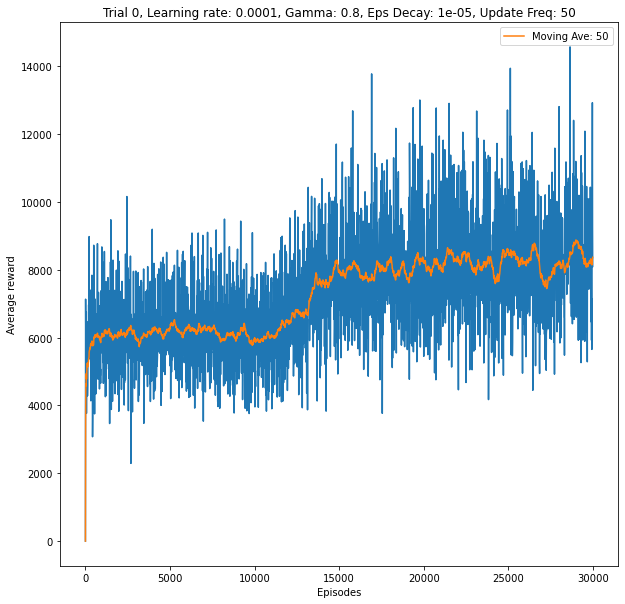

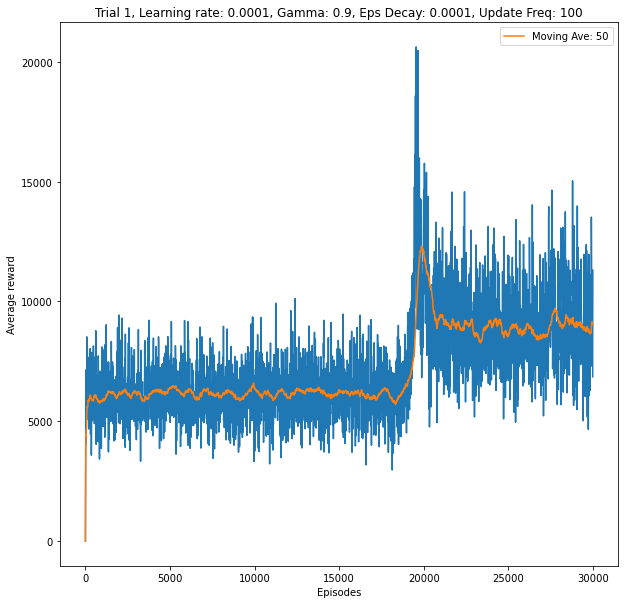

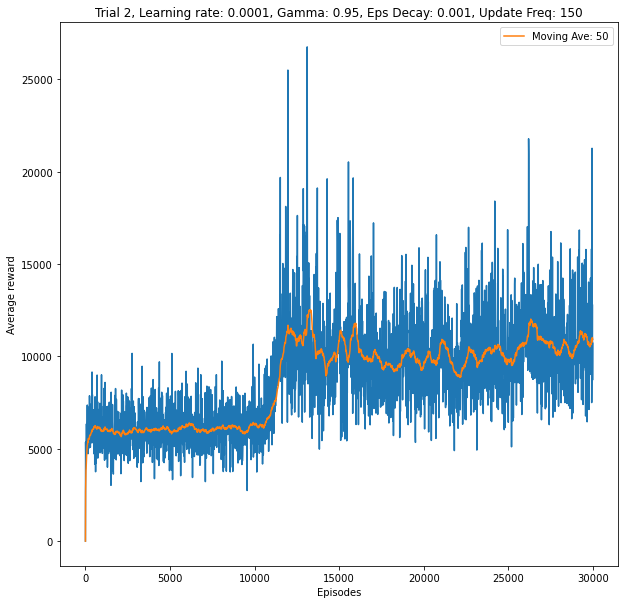

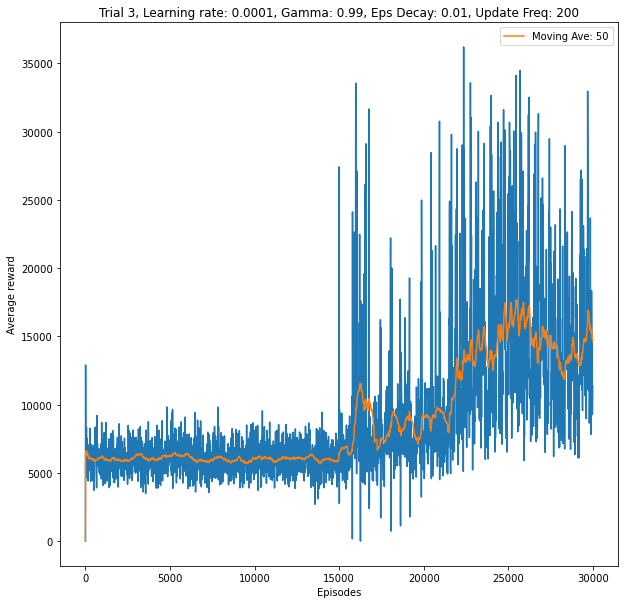

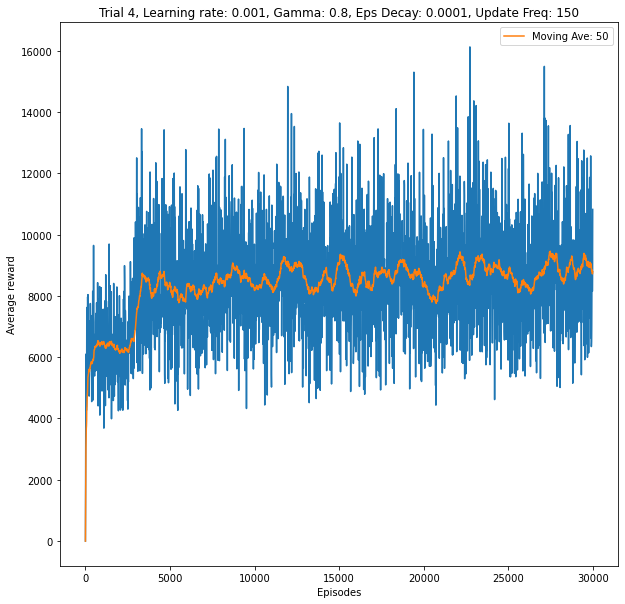

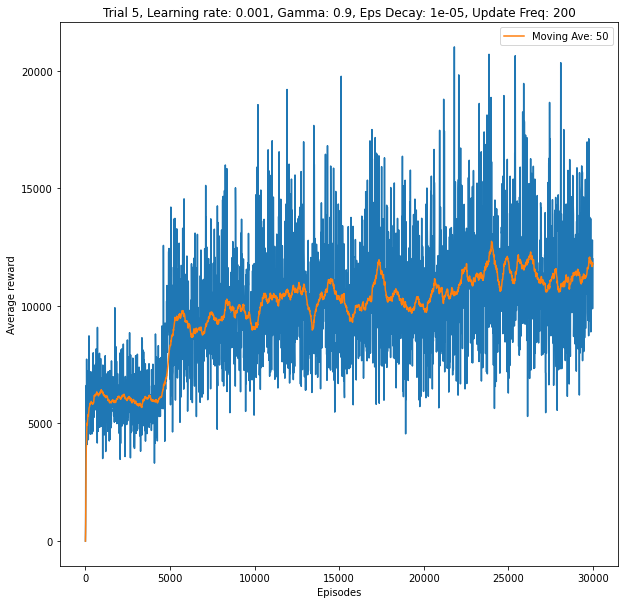

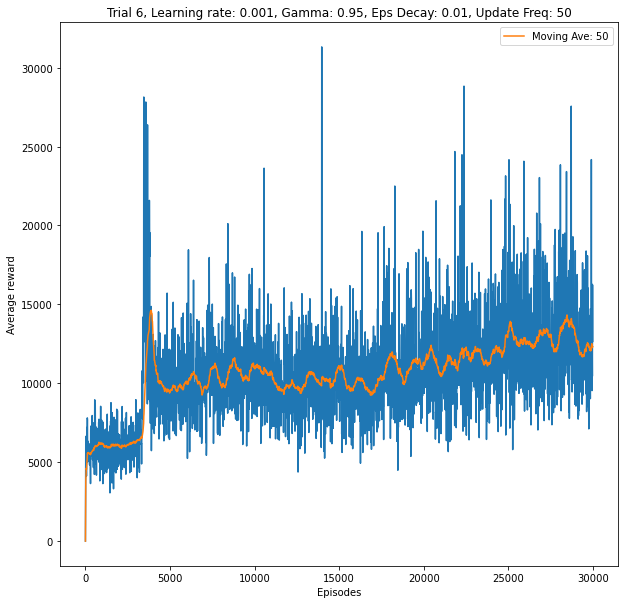

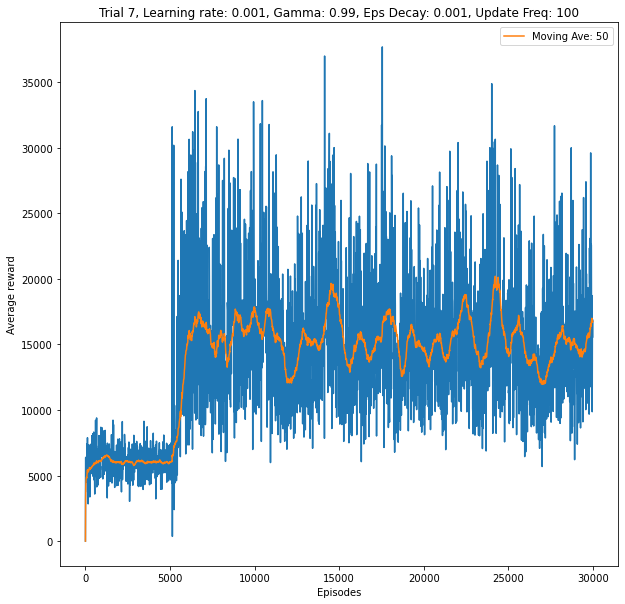

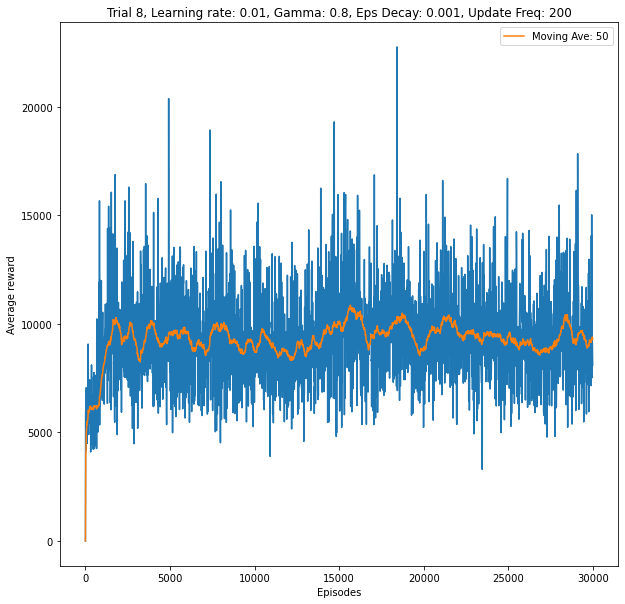

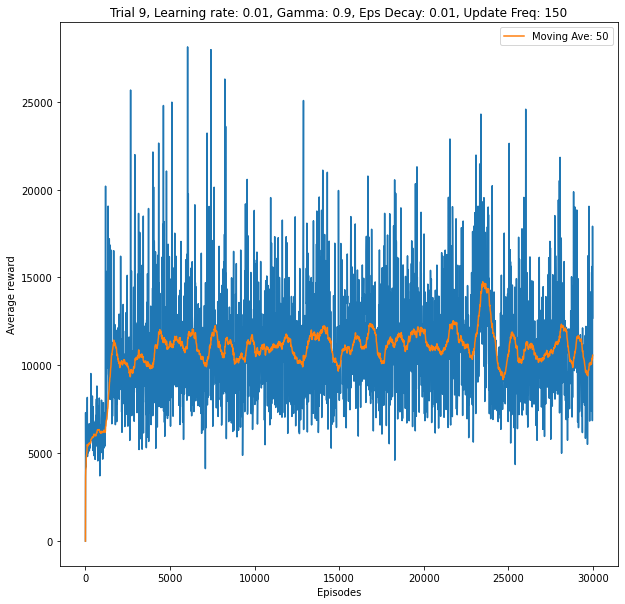

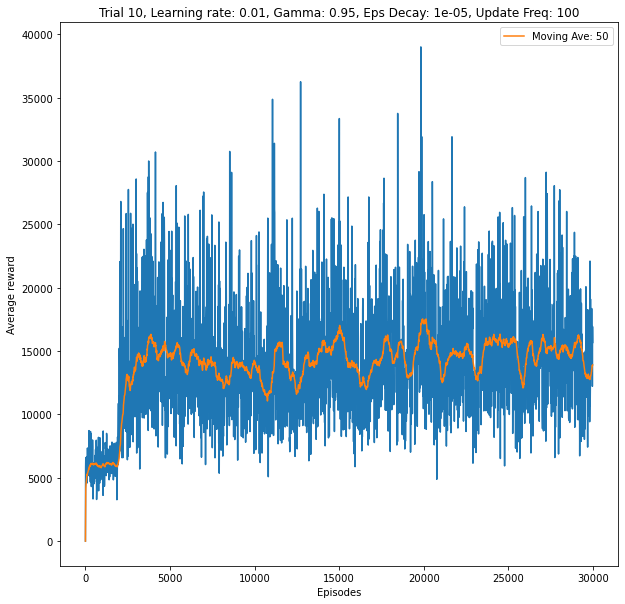

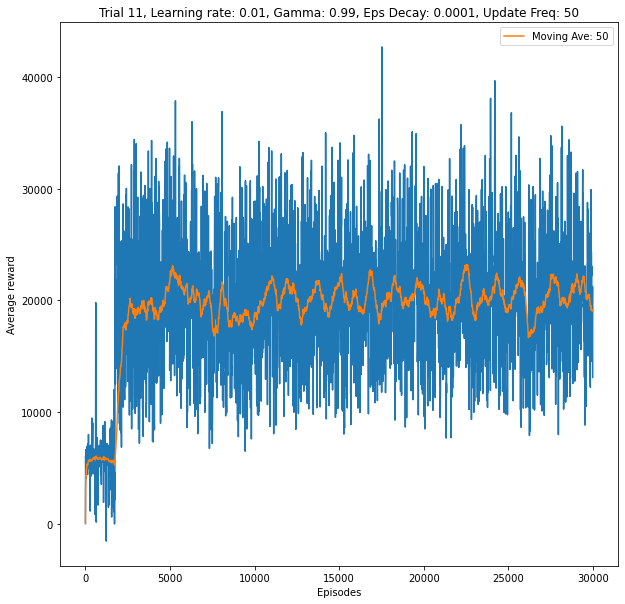

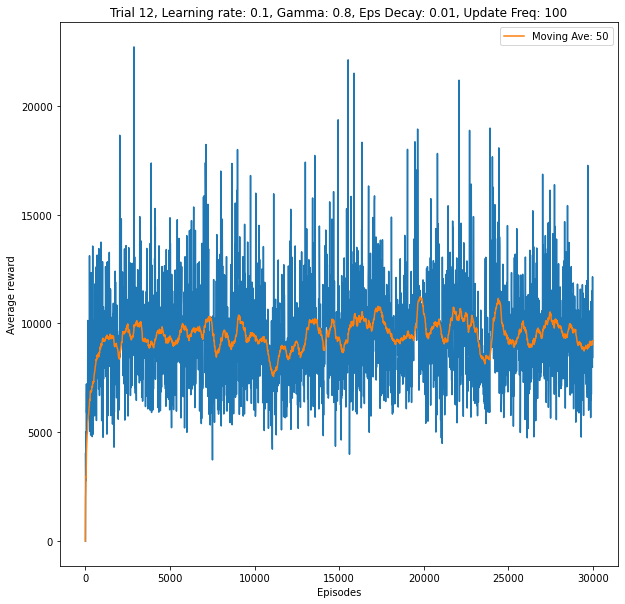

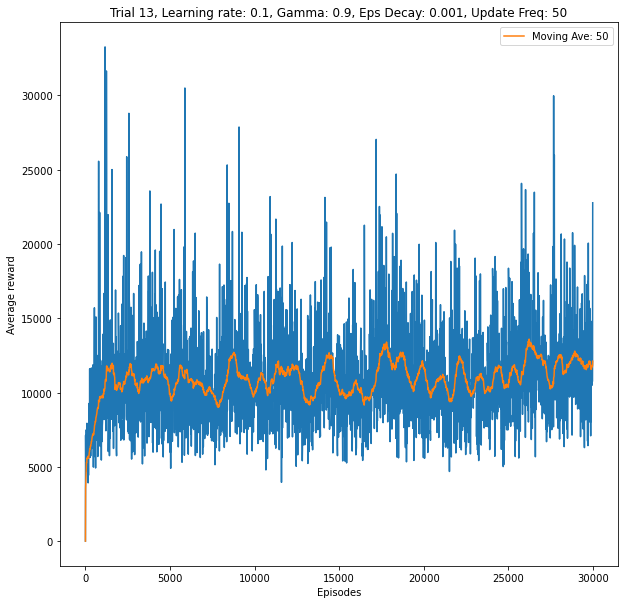

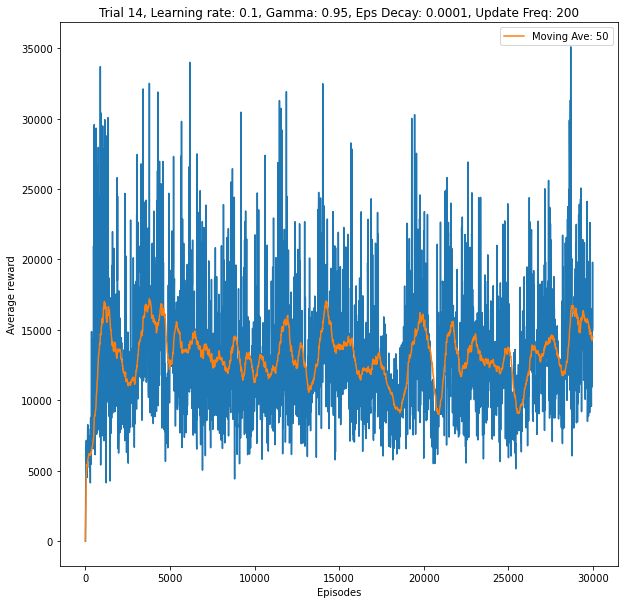

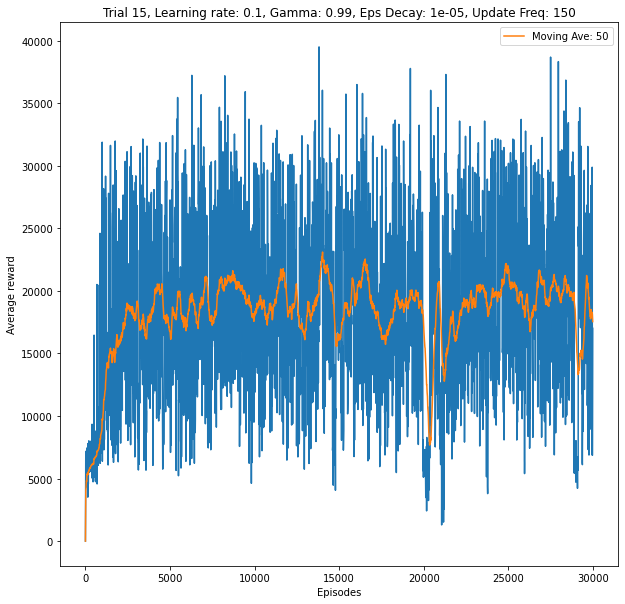

In [84]:
for i in range(len(params_array)):
    arr = params_array[i]
    fig = plt.figure(figsize=(10,10))
    plt.title(f"Trial {i}, Learning rate: {arr[0]}, Gamma: {arr[1]}, Eps Decay: {arr[2]}, Update Freq: {arr[3]}")
    data = np.loadtxt(f"run_2/trial_{i}.txt",delimiter = ',')
    
    df = pd.DataFrame(data)
    moving_ave = df.iloc[:,0].rolling(50,min_periods=1).mean().values.flatten().tolist()
    
    plt.plot(data[:,1],data[:,0])
    plt.plot(data[:,1],moving_ave,label = "Moving Ave: 50")
    plt.legend()
    plt.xlabel('Episodes')
    plt.ylabel('Average reward')